# Feature Extraction: HOG+

## Setup

In [1]:
#import libraries
import webdataset as wds
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2 as cv

from skimage import data, exposure
from skimage.feature import hog
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from PIL import Image

In [2]:
sns.set_theme(style="darkgrid")

In [3]:
#paths
root = '.'
data_folder = f'{root}/feature_data/corrected'
feature_data_folder = f'{root}/feature_data/hog+'

## Load Data

In [4]:
def load_data(path_to_data: str):
    """
    load 2D images and their labels

    returns: 
    images (array): array of images as np arrays
    labels (array): array of labels
    """
    #create lists to store images and labels
    images = []
    labels = []

    #load webdataset
    data = (wds.WebDataset(f'{path_to_data}', shardshuffle=True)
        .decode("pil")
        .to_tuple("jpg", "json")
        .map(lambda row: (np.array(row[0]), row[1]['label'])))

    #append dataset to lists
    for image, label in data:
        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    data.close()

    return images, labels

In [5]:
train_images, train_labels = load_data(f'file:{data_folder}/train-000000.tar')
val_images, val_labels = load_data(f'file:{data_folder}/val-000000.tar')
test_images, test_labels = load_data(f'file:{data_folder}/test-000000.tar')

7


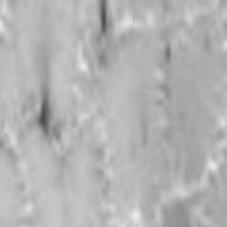

In [6]:
print(train_labels[0])
Image.fromarray(train_images[0])

In [7]:
print("Shape of images:", train_images.shape)
print("Shape of labels:", train_labels.shape)

Shape of images: (8430, 227, 227, 3)
Shape of labels: (8430,)


### View Class Samples

In [8]:
def plot_class_samples(images: list, labels: list):
    fig, axs = plt.subplots(nrows=1, ncols=len(images), figsize=(20,3))

    for i, (label, image) in enumerate(zip(labels, images)):
        ax = axs[i]
        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')

    fig.suptitle('One Image For Each Class')
    plt.show()

def load_class_samples(images: list, labels: list) -> tuple:
    label_names = ['crater', 'dark dune', 'slope streak', 'bright dune', 'impact ejecta', 'swiss cheese', 'spider']
    unique_labels = np.unique(labels)

    sample_images = []
    sample_labels = []

    for value in unique_labels:
        label = label_names[value - 1]
        index = int(np.where(train_labels==value)[0][0])

        sample_labels.append(label)
        sample_images.append(images[index])
    
    return sample_images, sample_labels

In [9]:
sample_imgs, sample_lbls = load_class_samples(train_images, train_labels)

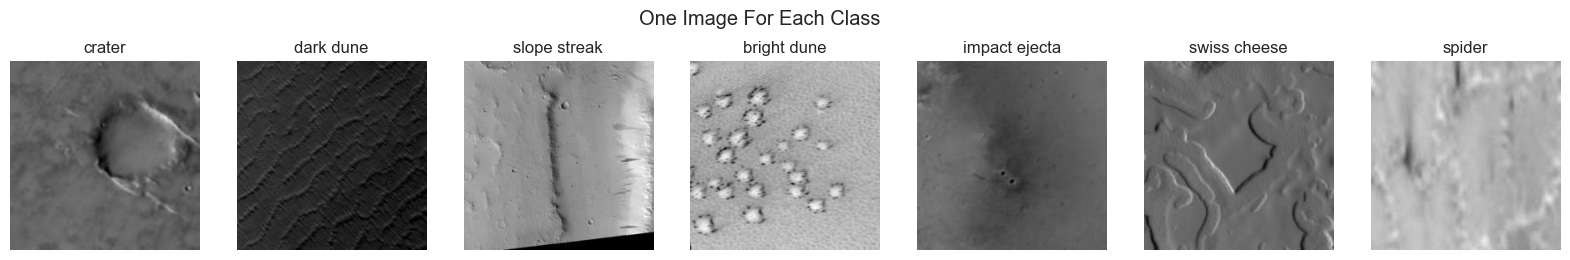

In [10]:
plot_class_samples(sample_imgs, sample_lbls)

## Feature Extraction: HOG

In [79]:
def get_hog_feature(imgs: list) -> tuple:
    hog_imgs = []
    hog_fts = []

    for img in imgs:
        #img = cv.GaussianBlur(img, (5, 5), 0)
        #img = cv.normalize(img, None, 0, 1, cv.NORM_MINMAX, cv.CV_32F)

        features, hog_img = hog(img,
                        orientations=8,
                        pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        visualize=True,
                        feature_vector=False,
                        channel_axis=-1)

        hog_imgs.append(hog_img)
        hog_fts.append(features)

    return np.array(hog_imgs), np.array(hog_fts)

def compute_histograms(data: list, bins=75) -> list:
    hist, _ = np.histogram(data, bins=bins)
    return hist

def get_hog_plus(hogs: list) -> list:
    mean_hist1 = np.mean(hogs, axis=1).reshape(len(hogs), -1)
    std_hist1 = np.std(hogs, axis=1).reshape(len(hogs), -1)
    min_hist1 = np.min(hogs, axis=1).reshape(len(hogs), -1)
    max_hist1 = np.max(hogs, axis=1).reshape(len(hogs), -1)
    mean_hist2 = np.mean(hogs, axis=(1, 2)).reshape(len(hogs), -1)
    std_hist2 = np.std(hogs, axis=(1, 2)).reshape(len(hogs), -1)
    min_hist2 = np.min(hogs, axis=(1, 2)).reshape(len(hogs), -1)
    max_hist2 = np.max(hogs, axis=(1, 2)).reshape(len(hogs), -1)
    median_hist1 = np.median(hogs, axis=1).reshape(len(hogs), -1)
    range_hist1 = (max_hist1 - min_hist1).reshape(len(hogs), -1)
    iqr_hist1 = (np.percentile(hogs, 75, axis=1) - np.percentile(hogs, 25, axis=1)).reshape(len(hogs), -1)
    median_hist2 = np.median(hogs, axis=(1, 2)).reshape(len(hogs), -1)
    range_hist2 = (max_hist2 - min_hist2).reshape(len(hogs), -1)
    iqr_hist2 = (np.percentile(hogs, 75, axis=(1, 2)) - np.percentile(hogs, 25, axis=(1, 2))).reshape(len(hogs), -1)

    mean_hist1 = np.apply_along_axis(compute_histograms, axis=1, arr=mean_hist1, bins=50)
    std_hist1 = np.apply_along_axis(compute_histograms, axis=1, arr=std_hist1, bins=50)
    min_hist1 = np.apply_along_axis(compute_histograms, axis=1, arr=min_hist1, bins=50)
    max_hist1 = np.apply_along_axis(compute_histograms, axis=1, arr=max_hist1, bins=50)
    median_hist1 = np.apply_along_axis(compute_histograms, axis=1, arr=median_hist1, bins=50)
    range_hist1 = np.apply_along_axis(compute_histograms, axis=1, arr=range_hist1, bins=50)
    iqr_hist1 = np.apply_along_axis(compute_histograms, axis=1, arr=iqr_hist1, bins=50)
    mean_hist2 = np.apply_along_axis(compute_histograms, axis=1, arr=mean_hist2, bins=50)
    std_hist2 = np.apply_along_axis(compute_histograms, axis=1, arr=std_hist2, bins=50)
    min_hist2 = np.apply_along_axis(compute_histograms, axis=1, arr=min_hist2, bins=50)
    max_hist2 = np.apply_along_axis(compute_histograms, axis=1, arr=max_hist2, bins=50)
    median_hist2 = np.apply_along_axis(compute_histograms, axis=1, arr=median_hist2, bins=50)
    range_hist2 = np.apply_along_axis(compute_histograms, axis=1, arr=range_hist2, bins=50)
    iqr_hist2 = np.apply_along_axis(compute_histograms, axis=1, arr=iqr_hist2, bins=50)

    return np.hstack([
        mean_hist1, std_hist1, min_hist1, max_hist1, median_hist1, range_hist1, iqr_hist1,
        mean_hist2, std_hist2, min_hist2, max_hist2, median_hist2, range_hist2, iqr_hist2
    ])

def plot_hog_helper(df):
    _, axs = plt.subplots(7, 2, figsize=(20, 20))
    axs = axs.ravel()

    count_col = get_col_types()

    for i, y in enumerate(count_col):
        ax = sns.barplot(df, x='x', y=y, hue='hue', palette='husl', dodge=False, alpha=0.5, ax=axs[i])
        ax.set_xlabel('Bin')
        ax.set_ylabel('Count')
        ax.set_title(f'Hog binning of {y}')
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    plt.tight_layout()
    plt.show()

def hog_plus_unravel(hog_plus: list, bin_size: int=50) -> dict:
    return {
        col_type: hog_plus[:, bin_size*i:bin_size*(i+1)].flatten()
        for i, col_type in enumerate(get_col_types())
    }

def get_col_types() -> list:
    return [
        'mean_hist1',
        'std_hist1',
        'min_hist1',
        'max_hist1',
        'median_hist1',
        'range_hist1',
        'iqr_hist1',
        'mean_hist2',
        'std_hist2',
        'min_hist2',
        'max_hist2',
        'median_hist2',
        'range_hist2',
        'iqr_hist2',
    ]

def get_hog_plus_df(hog_plus: list, labels: list, bin_size: int=50):
    data = hog_plus_unravel(hog_plus, bin_size)
    data['x'] = np.tile(np.arange(0, bin_size), len(hog_plus))
    data['hue'] = np.repeat([label for label in labels], bin_size)
    return pd.DataFrame(data)

def plot_hog_plus(hog_plus: list, labels: list, bin_size: int=50):
    df = get_hog_plus_df(hog_plus, labels, bin_size)
    plot_hog_helper(df)

def plot_hog_plus_avgs(hog_plus: list, labels: list, bin_size: int=50):
    df = get_hog_plus_df(hog_plus, labels, bin_size)
    df = df.groupby(['x', 'hue']).mean().reset_index()
    plot_hog_helper(df)

def plot_hog_samples(sample_hogs: list, sample_labels: list):
    fig, axs = plt.subplots(nrows=1, ncols=len(sample_imgs), figsize=(20,3))

    samples = zip(sample_labels, sample_hogs)

    for i, (label, img) in enumerate(samples):
        ax = axs[i]

        img = exposure.rescale_intensity(img, in_range=(0, 10))
        ax.imshow(img, cmap='gray')
        ax.set_title(label)
        ax.axis('off')

    fig.suptitle('HOG Features per Class')
    plt.show()

### View Hog Sample

In [12]:
sample_hogs, sample_features = get_hog_feature(sample_imgs)

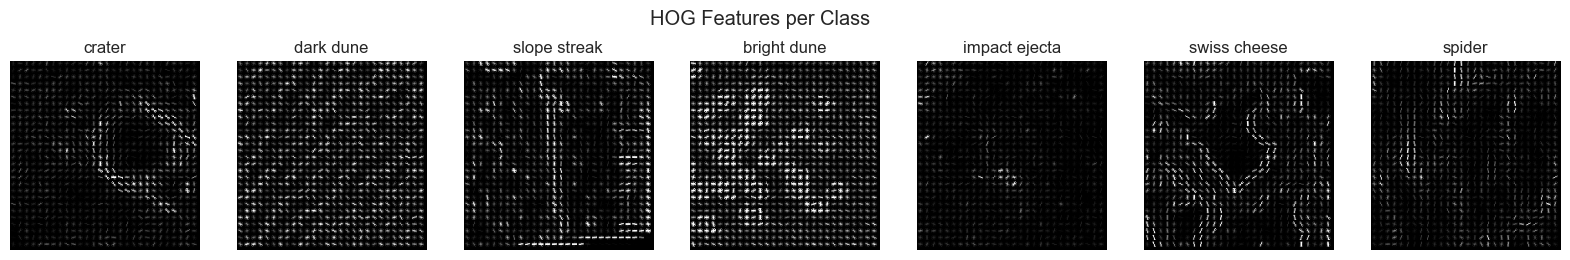

In [13]:
plot_hog_samples(sample_hogs, sample_lbls)

In [52]:
sample_hog_plus = get_hog_plus(sample_features)
sample_hog_plus.shape

(7, 700)

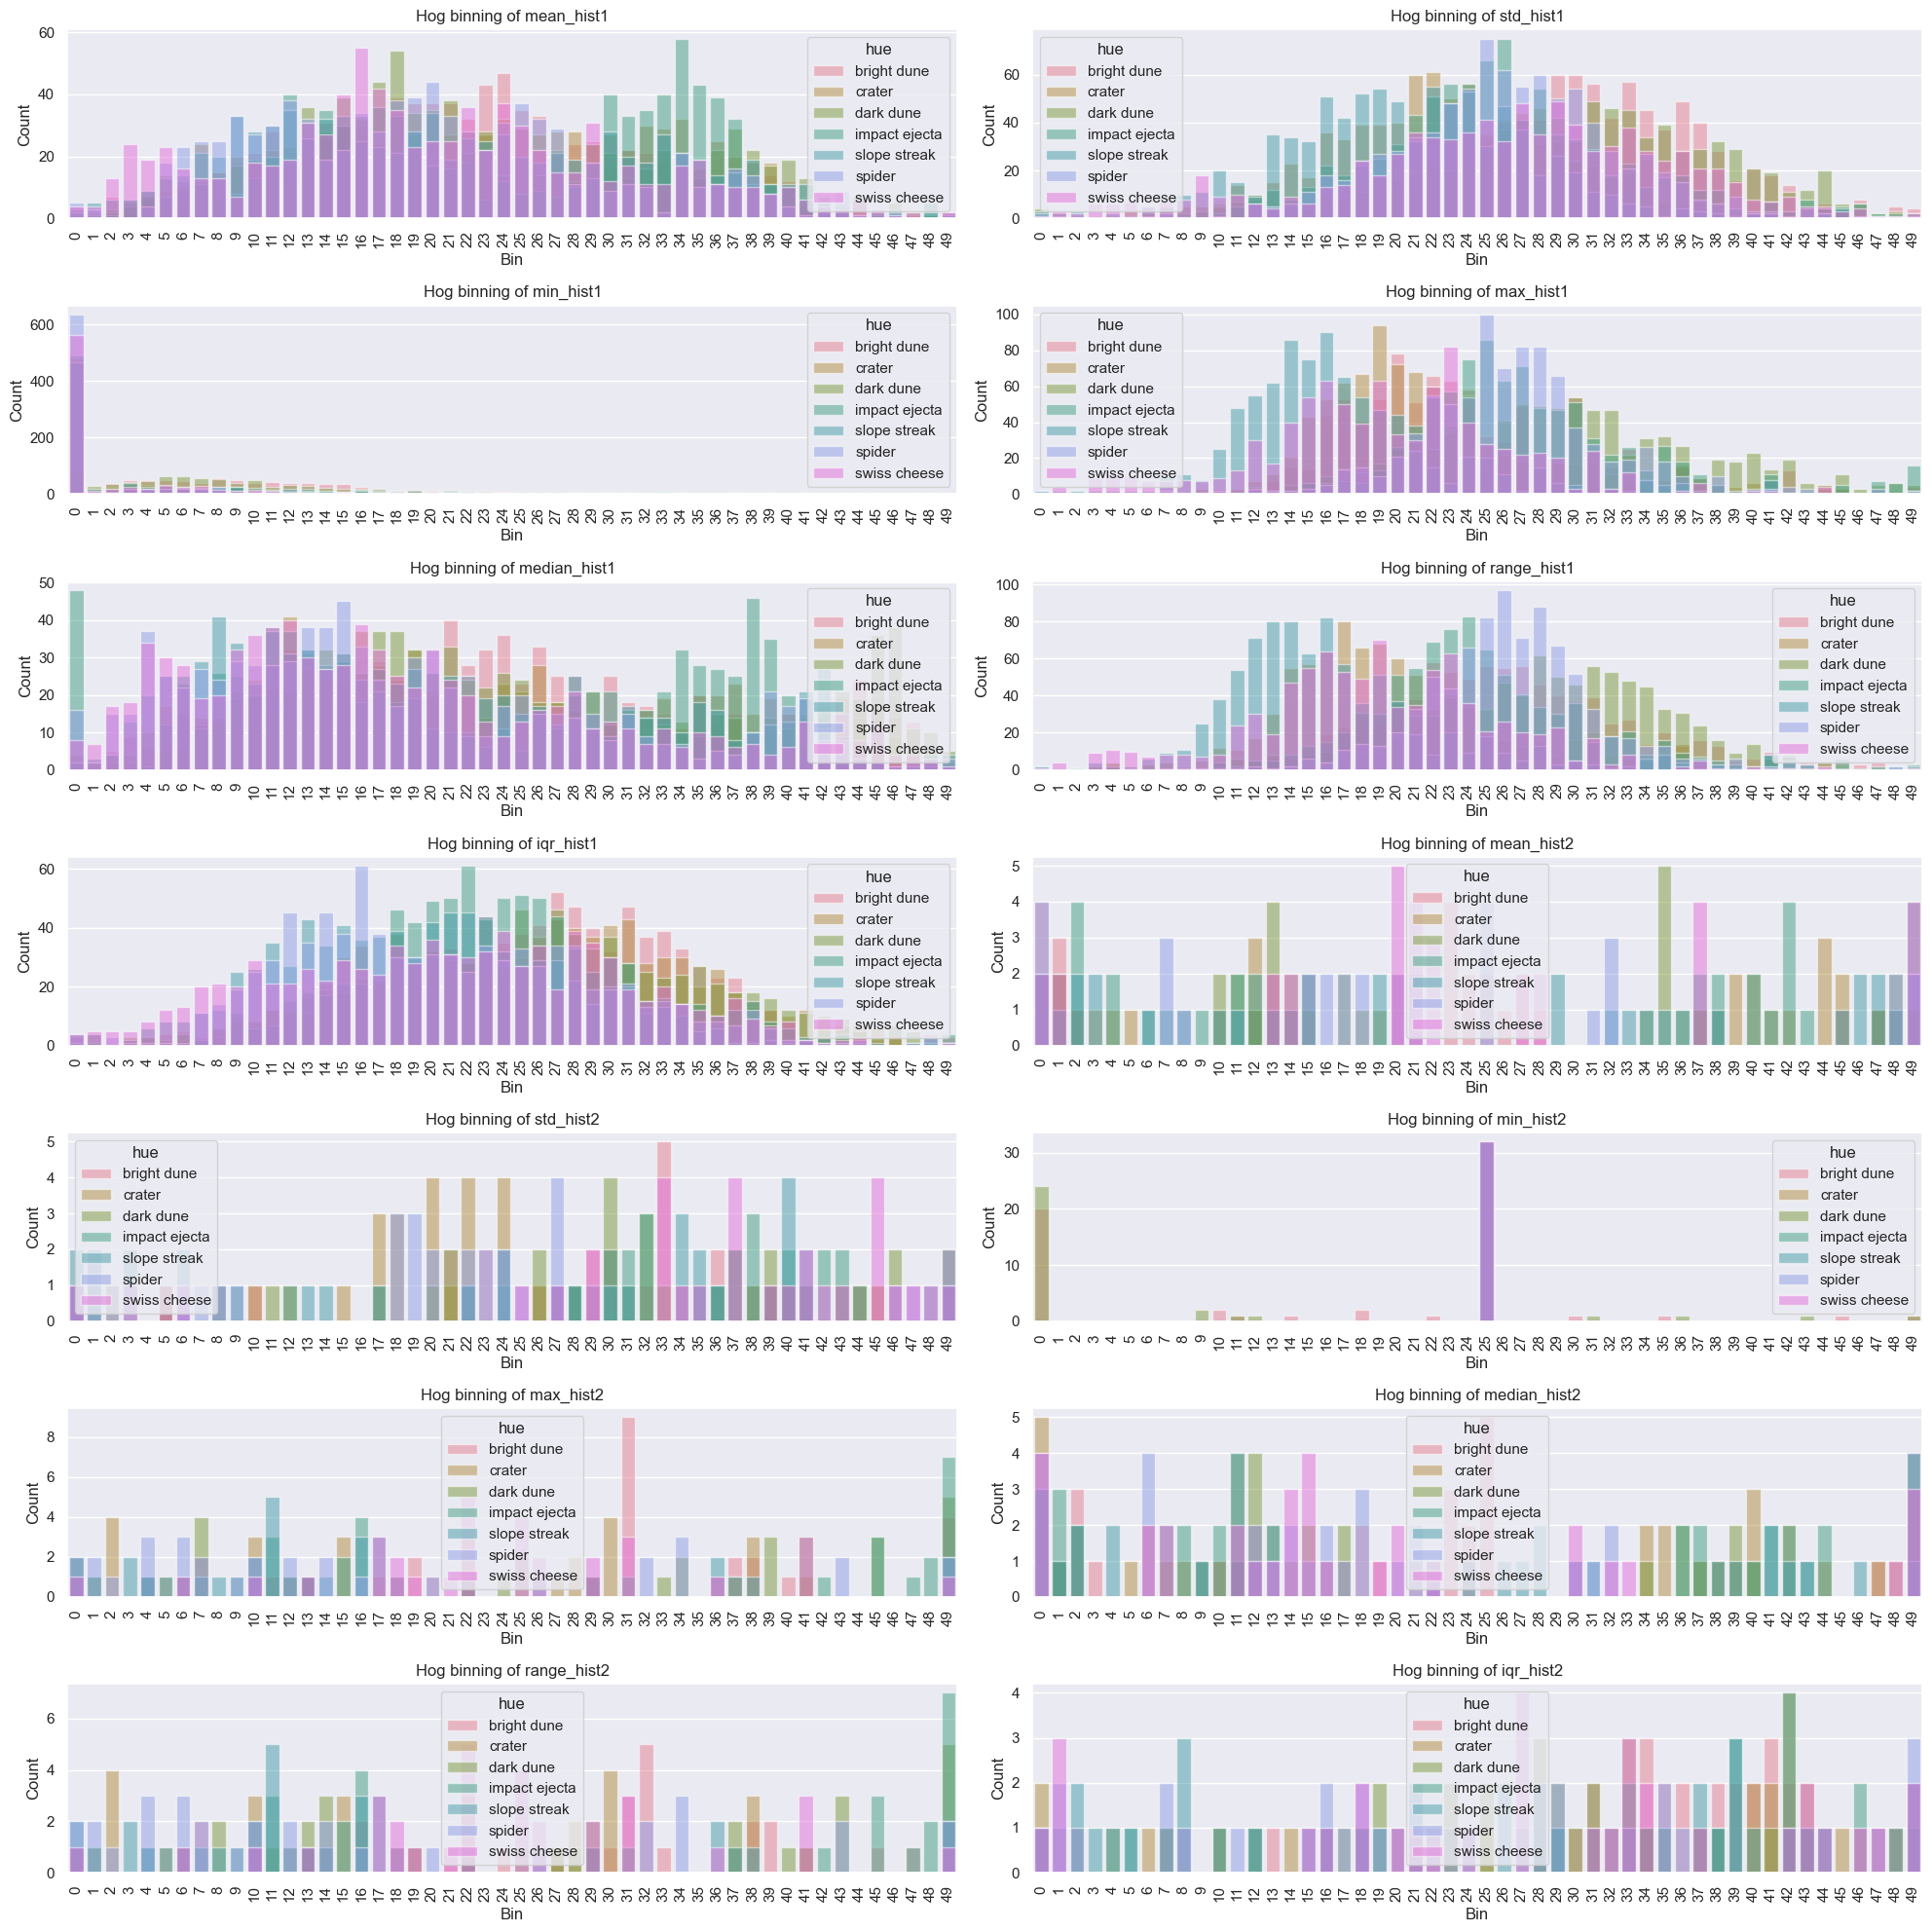

In [80]:
plot_hog_plus_avgs(sample_hog_plus, sample_lbls, bin_size=50)

In [25]:
_, train_hog = get_hog_feature(train_images)
_, val_hog = get_hog_feature(val_images)
_, test_hog = get_hog_feature(test_images)

In [26]:
train_hog.shape, val_hog.shape, test_hog.shape

((8430, 27, 27, 2, 2, 8), (2798, 27, 27, 2, 2, 8), (403, 27, 27, 2, 2, 8))

In [27]:
#save files
np.save(f'{root}/feature_data/hog/train_hog.npy', train_hog)
np.save(f'{root}/feature_data/hog/val_hog.npy', val_hog)
np.save(f'{root}/feature_data/hog/test_hog.npy', test_hog)

In [81]:
train_hog = np.load(f'{root}/feature_data/hog/train_hog.npy')
val_hog = np.load(f'{root}/feature_data/hog/val_hog.npy')
test_hog = np.load(f'{root}/feature_data/hog/test_hog.npy')

In [82]:
train_hog = get_hog_plus(train_hog)
val_hog = get_hog_plus(val_hog)
test_hog = get_hog_plus(test_hog)

In [83]:
train_hog.shape, val_hog.shape, test_hog.shape

((8430, 700), (2798, 700), (403, 700))

In [84]:
#save files
np.save(f'{feature_data_folder}/train_hog.npy', train_hog)
np.save(f'{feature_data_folder}/val_hog.npy', val_hog)
np.save(f'{feature_data_folder}/test_hog.npy', test_hog)

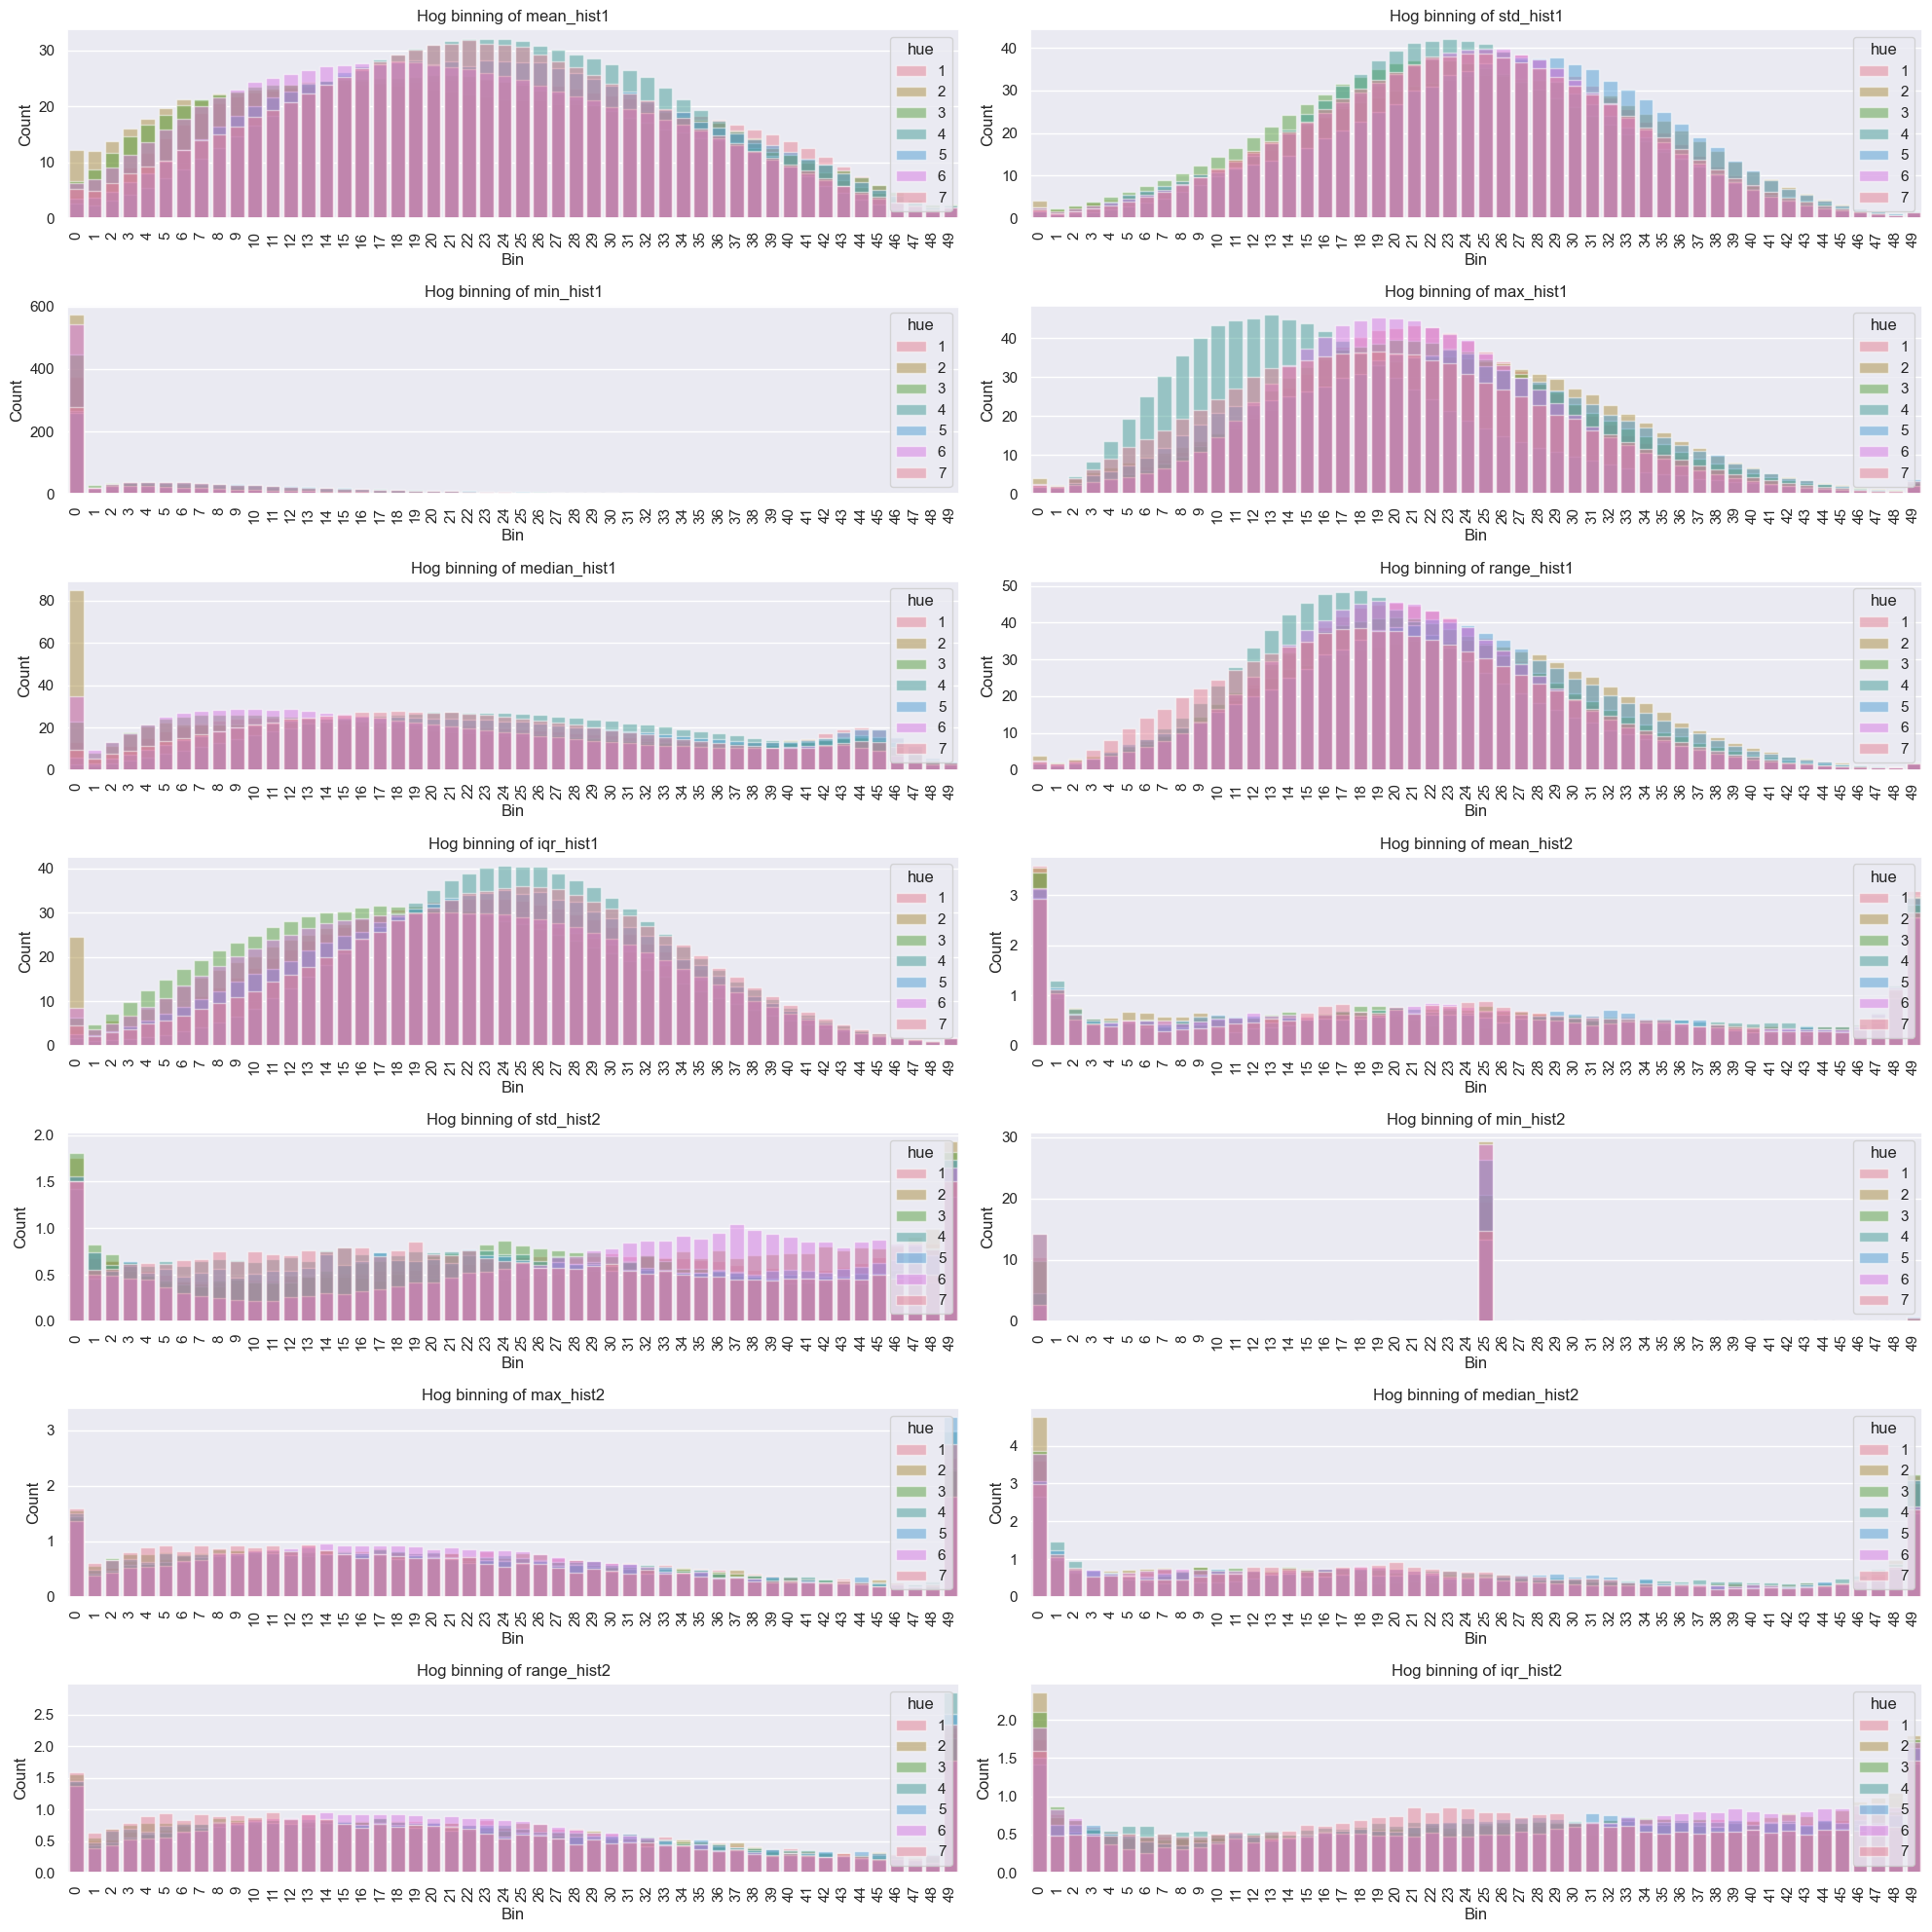

In [85]:
plot_hog_plus_avgs(train_hog, train_labels, bin_size=50)

## PCA

In [86]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_hog)

In [87]:
pca = PCA()
pca.fit(train_hog)

PCA()

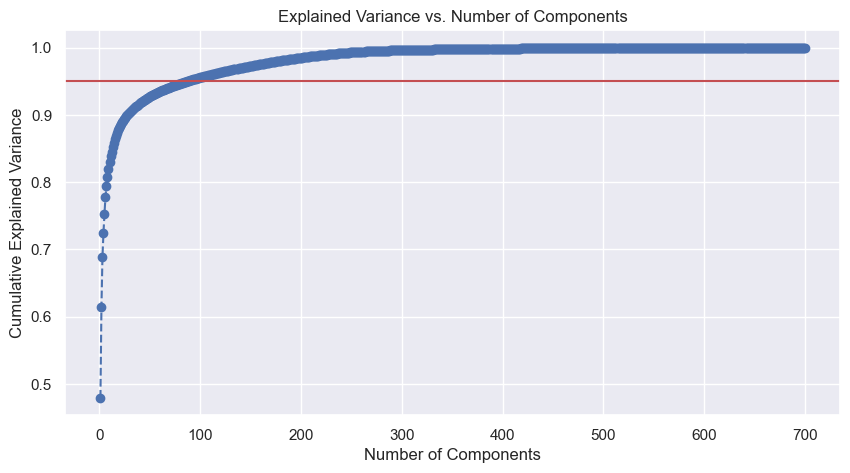

In [88]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

## PCA down to 1000, $\approx 95\%$

In [89]:
pca = PCA(n_components=200) #1000 on original
pca.fit(X_scaled)

PCA(n_components=200)

In [90]:
train_hog = pca.transform(scaler.transform(train_hog))
val_hog = pca.transform(scaler.transform(val_hog))
test_hog = pca.transform(scaler.transform(test_hog))

In [91]:
np.save(f'{feature_data_folder}/pca_train_hog.npy', train_hog)
np.save(f'{feature_data_folder}/pca_val_hog.npy', val_hog)
np.save(f'{feature_data_folder}/pca_test_hog.npy', test_hog)

## t-SNE

In [92]:
tsne = TSNE(n_components=2)
reduced_data = tsne.fit_transform(train_hog)

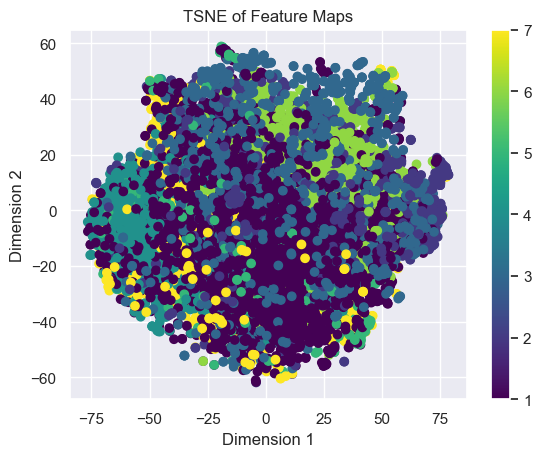

In [93]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=train_labels, cmap='viridis', marker='o')
plt.title('TSNE of Feature Maps')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar()
plt.show()

### Predictive Power

In [185]:
from sklearn import svm

In [189]:
clf = svm.SVC(class_weight='balanced').fit(train_hog, train_labels)

In [94]:
clf = LogisticRegression().fit(train_hog, train_labels)

In [256]:
clf = HistGradientBoostingClassifier(max_iter=100, learning_rate=0.05, class_weight='balanced').fit(train_hog, train_labels)

In [95]:
clf.score(train_hog, train_labels)

0.6721233689205219

In [96]:
clf.score(val_hog, val_labels)

0.543602573266619

In [236]:
preds = clf.predict(train_hog)
corr = preds == train_labels
df_train = pd.DataFrame({'correct': corr, 'label': train_labels})

In [237]:
preds = clf.predict(val_hog)
corr = preds == val_labels
df_val = pd.DataFrame({'correct': corr, 'label': val_labels})

Text(0, 0.5, 'Count')

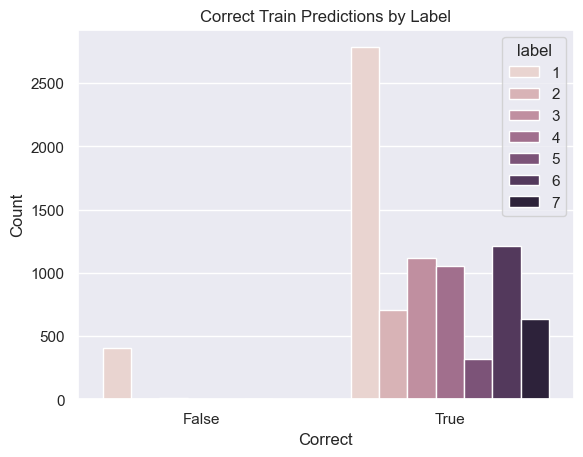

In [238]:
ax = sns.countplot(df_train, x='correct', hue='label')
ax.set_title('Correct Train Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

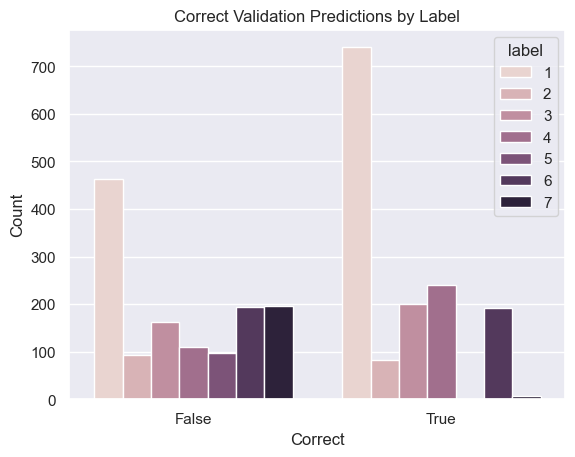

In [239]:
ax = sns.countplot(df_val, x='correct', hue='label')
ax.set_title('Correct Validation Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')